In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [5]:
df = pd.read_csv('/train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [6]:
df.isnull().sum()

,0
date,0
store,0
item,0
sales,0


Data Preprocessing

In [7]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [8]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,21,2017,10,1,6
1,2017-10-02,1,1,12,2017,10,2,7
2,2017-10-03,1,1,18,2017,10,3,1
3,2017-10-04,1,1,15,2017,10,4,2
4,2017-10-05,1,1,20,2017,10,5,3


Data Exploration

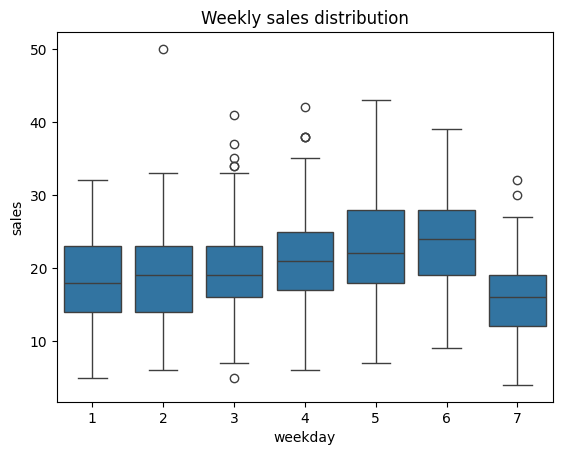

In [9]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

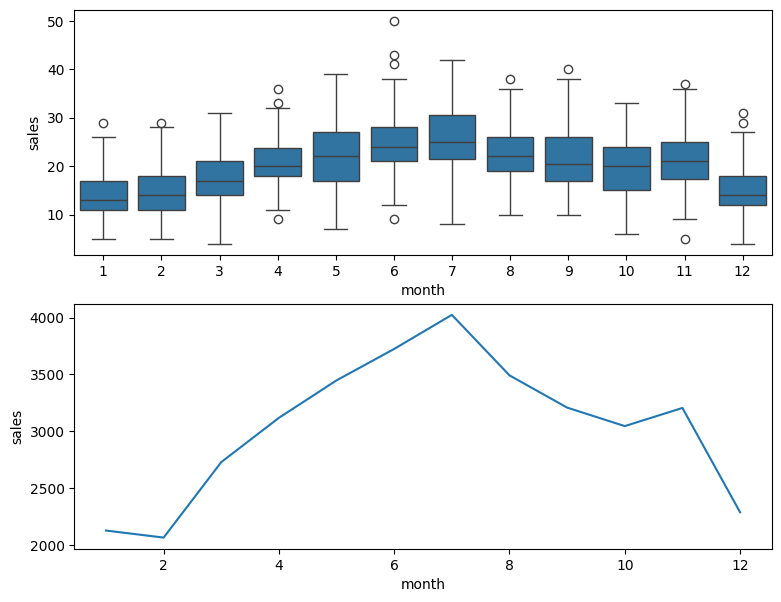

In [10]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

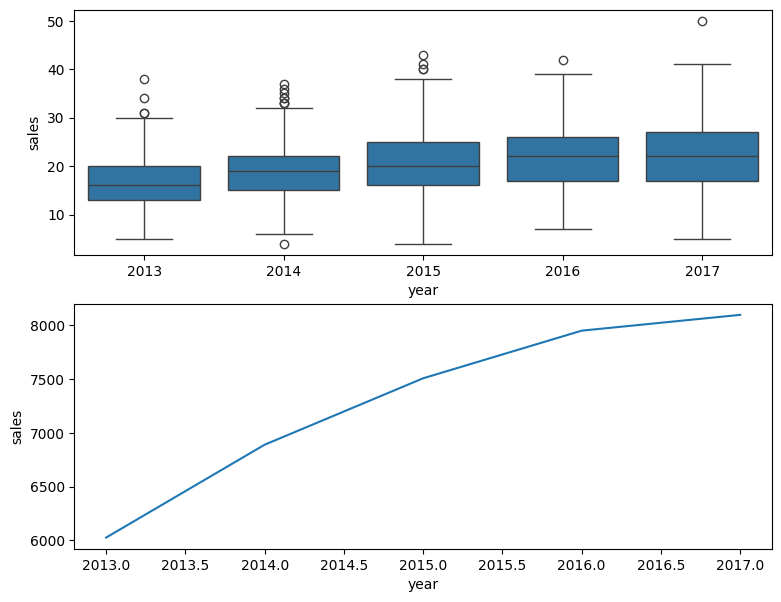

In [11]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

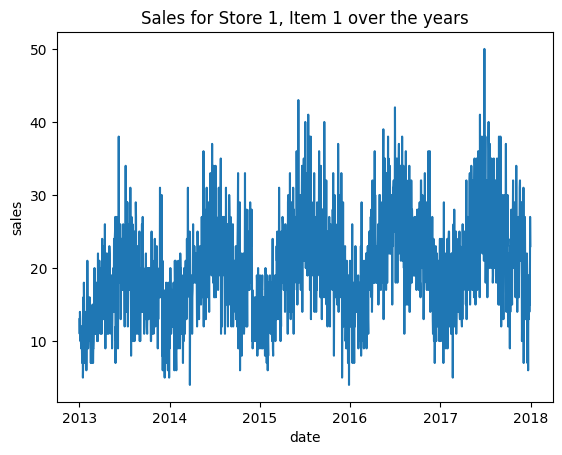

In [12]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

Quantitative Methods to Forecast Product Sales

In [14]:
# subtract 1 year from test data dates
dates = (test_df['date'] - pd.DateOffset(years=1)).dt.floor('D')

# get sales from training data where dates match the shifted dates
seasonal_naive_sales = train_df.loc[train_df['date'].dt.floor('D').isin(dates), 'sales']

# make a copy of the test_df and add naive predictions
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = seasonal_naive_sales.values
sn_pred_df.head()

,date,store,item,year,month,day,weekday,seasonal_naive_sales
0,2017-10-01,1,1,2017,10,1,6,25
1,2017-10-02,1,1,2017,10,2,7,26
2,2017-10-03,1,1,2017,10,3,1,20
3,2017-10-04,1,1,2017,10,4,2,28
4,2017-10-05,1,1,2017,10,5,3,17


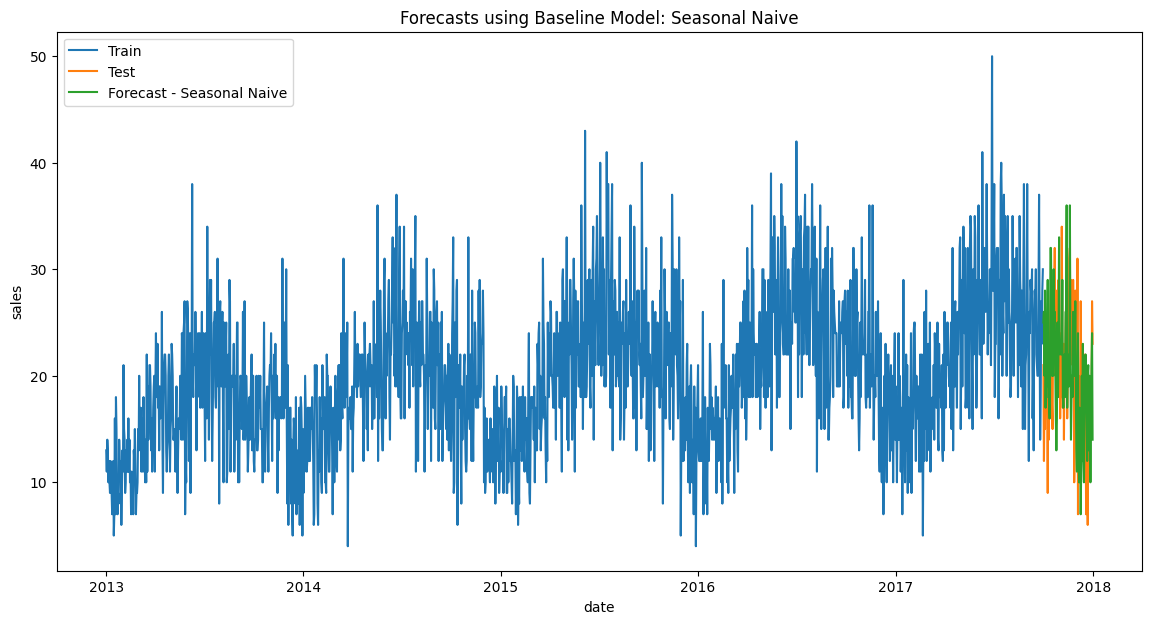

In [15]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

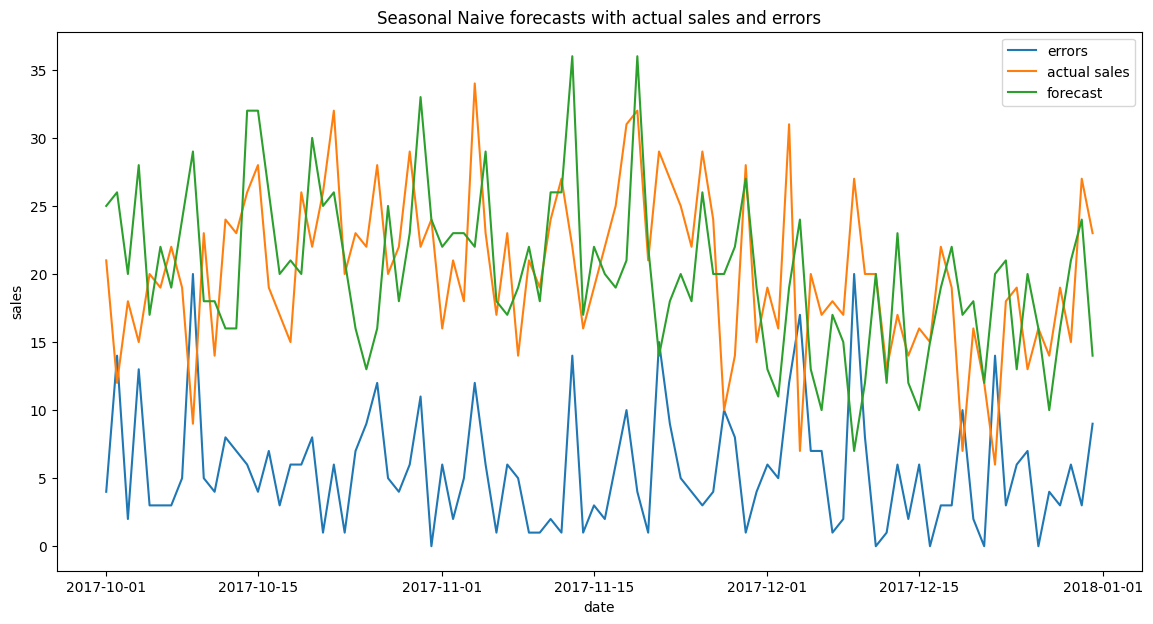

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1861,1857,4,5.630435,7.130766,27.834498


In [16]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))


plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

Time Series Decomposition Plot

In [17]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 640x480 with 0 Axes>

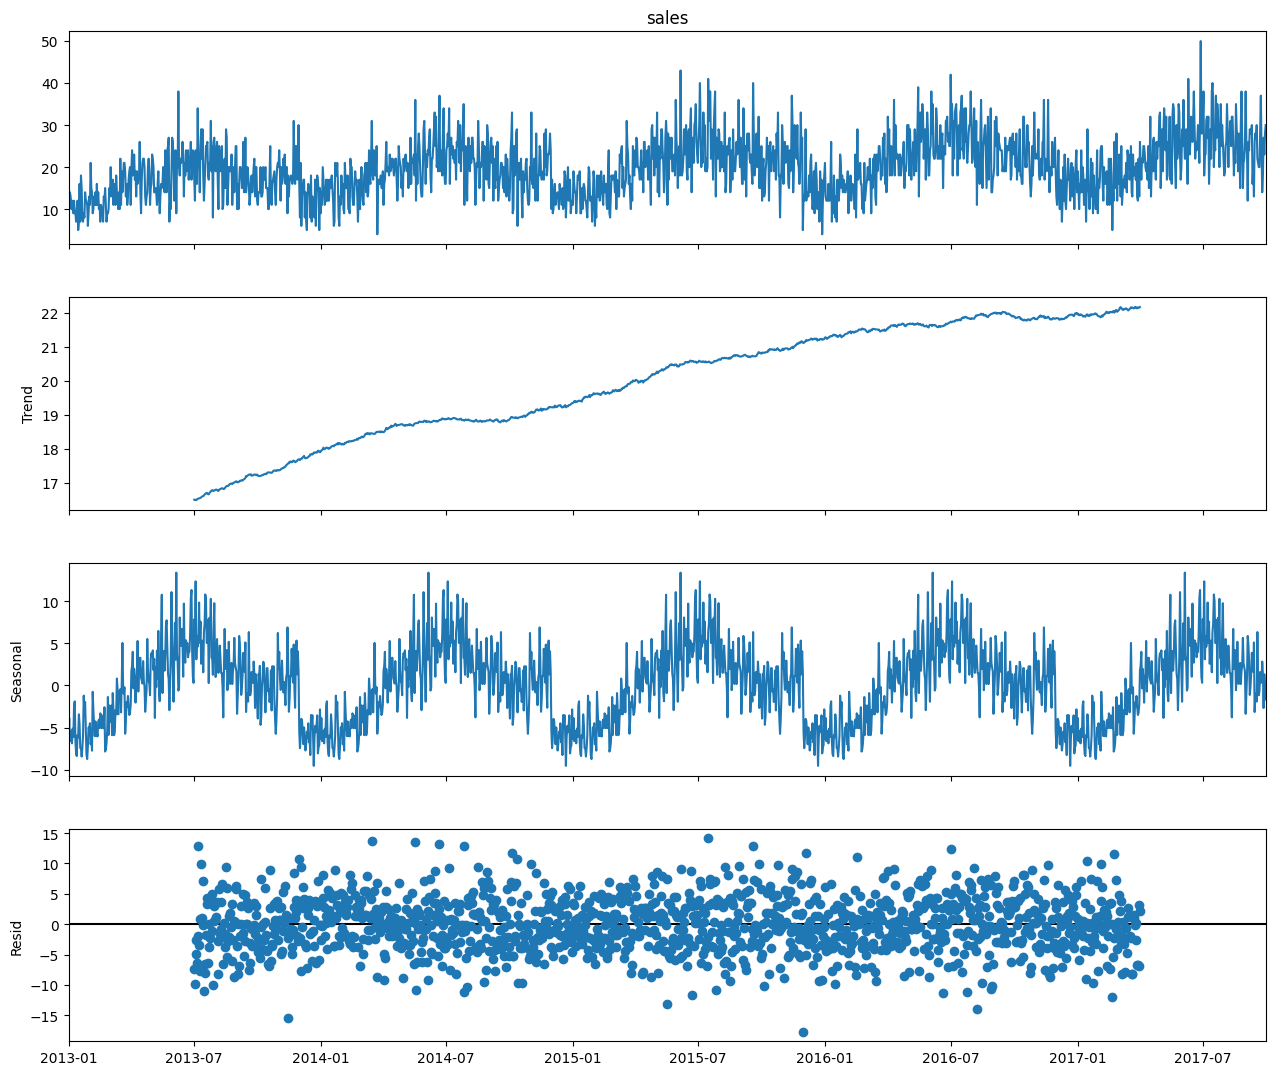

In [20]:
# Correct seasonal decomposition with proper parameter name
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', period=365)

# Plot the results
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)
plt.show()

Holt Winter's Triple Exponential Smoothing Model

In [37]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True, use_boxcox=False)
hw_fit_2 = hw_model_2.fit(remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()
print('Forecasts made, ready for evaluation')

Forecasts made, ready for evaluation


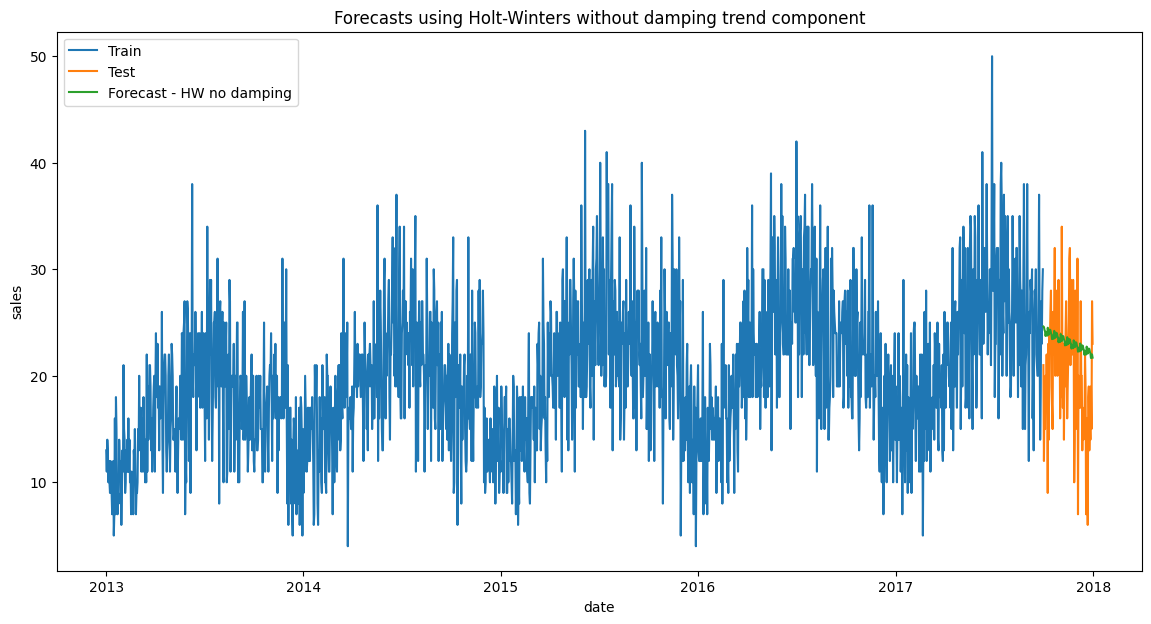

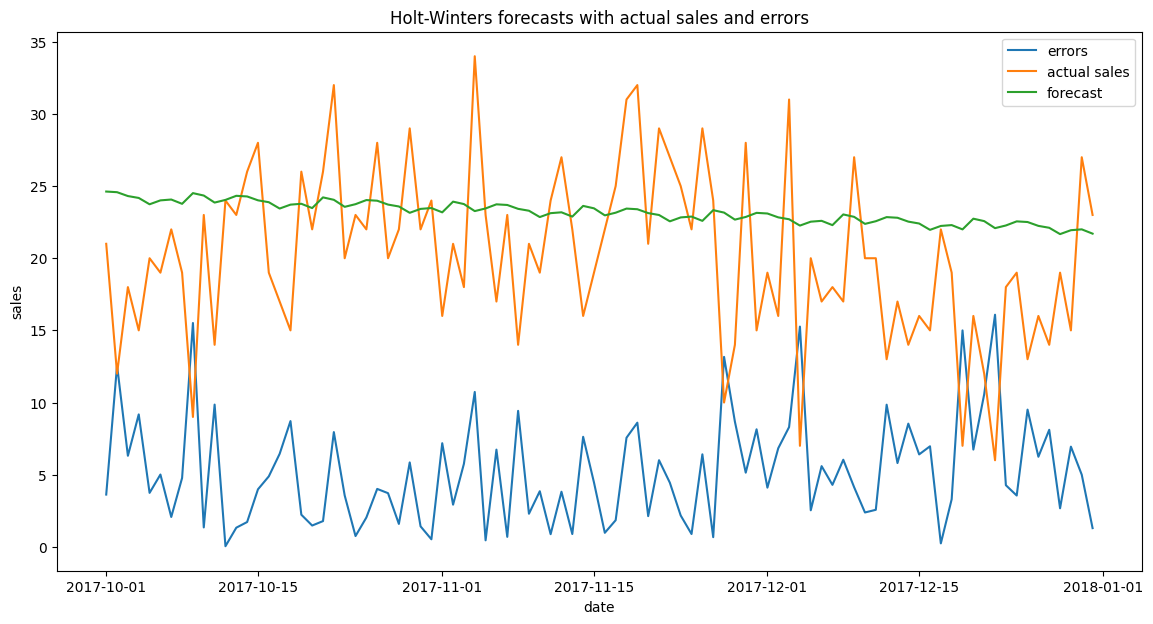

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,1861,2132.536302,-271.536302,5.235092,6.430953,25.880088


In [38]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_hw

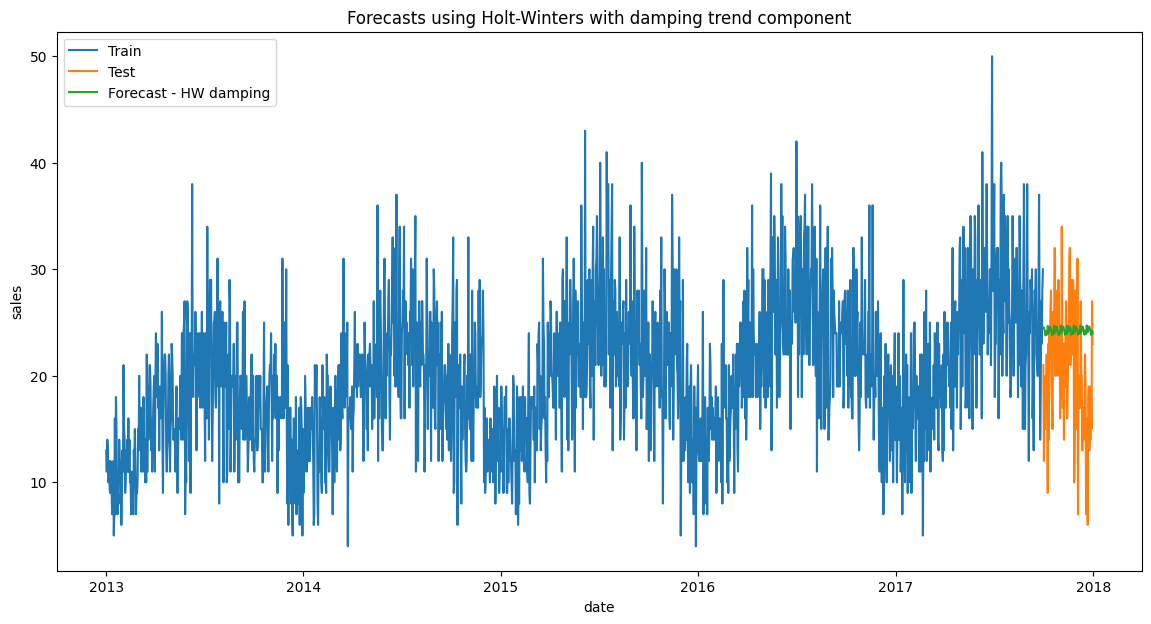

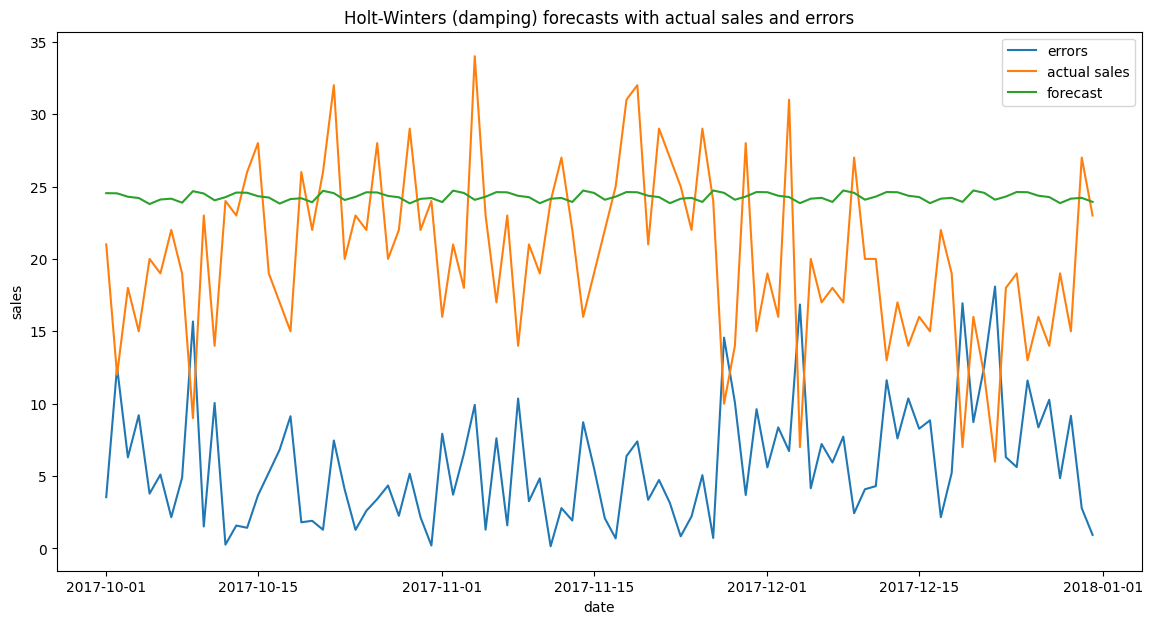

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,1861,2234.806611,-373.806611,5.820579,7.102234,28.774489


In [39]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_hwd

Supervised Machine Learning: Linear Regression

In [40]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,2
1822,2017-12-28,1,1,19,2017,12,28,3
1823,2017-12-29,1,1,15,2017,12,29,4
1824,2017-12-30,1,1,27,2017,12,30,5


Feature Engineering

In [41]:
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)

# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-09-30']
reg_test_df = reg_df.loc['2017-10-01':]

Feature Selection and Model Building

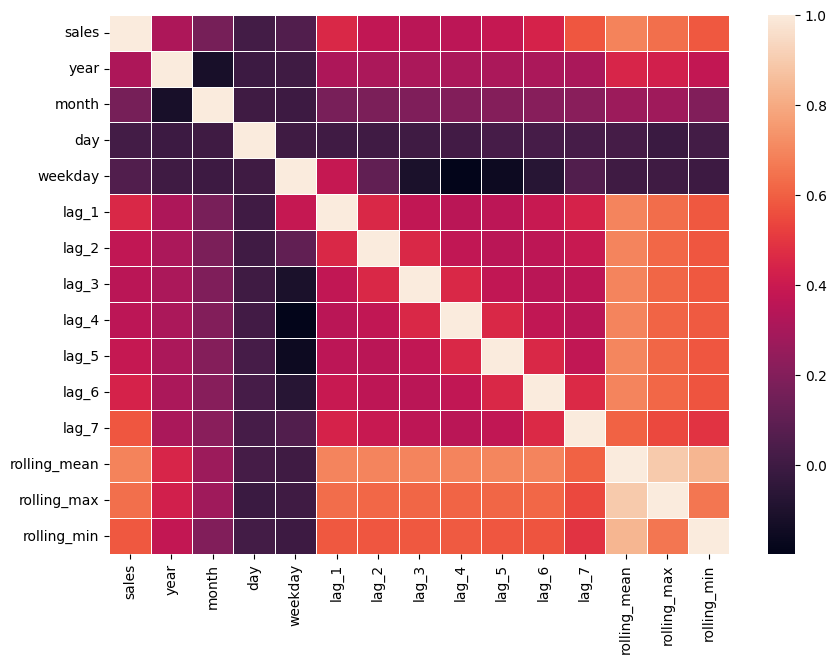

In [42]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [43]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
11  rolling_mean  1577.946956
12   rolling_max  1170.464035
13   rolling_min   888.451268
10         lag_7   860.565955
4          lag_1   449.743115


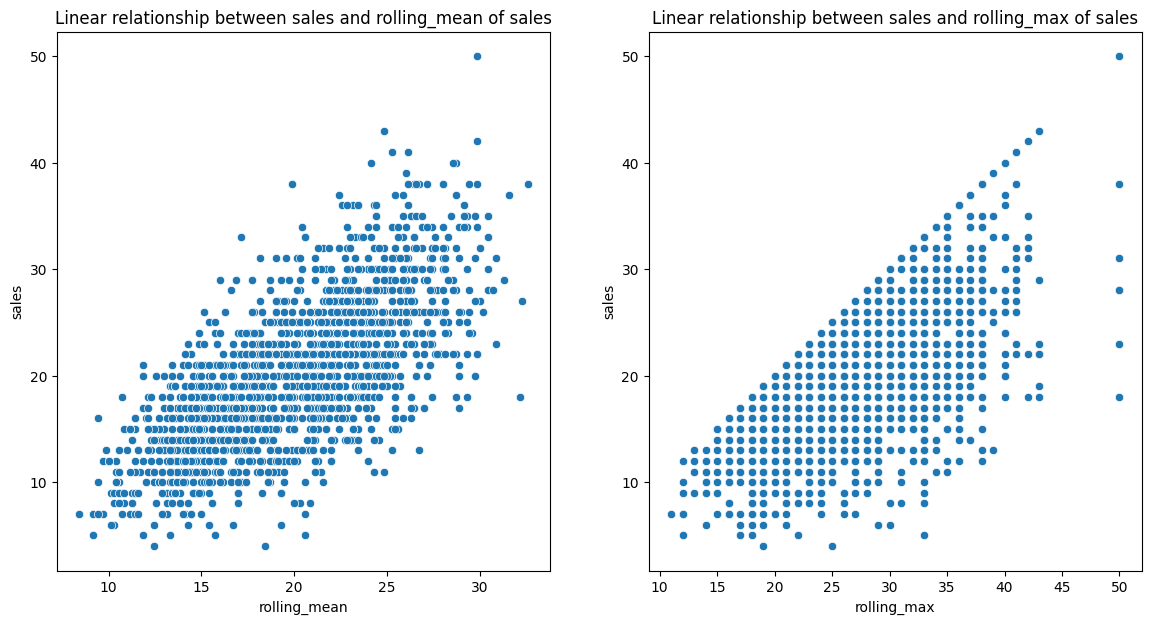

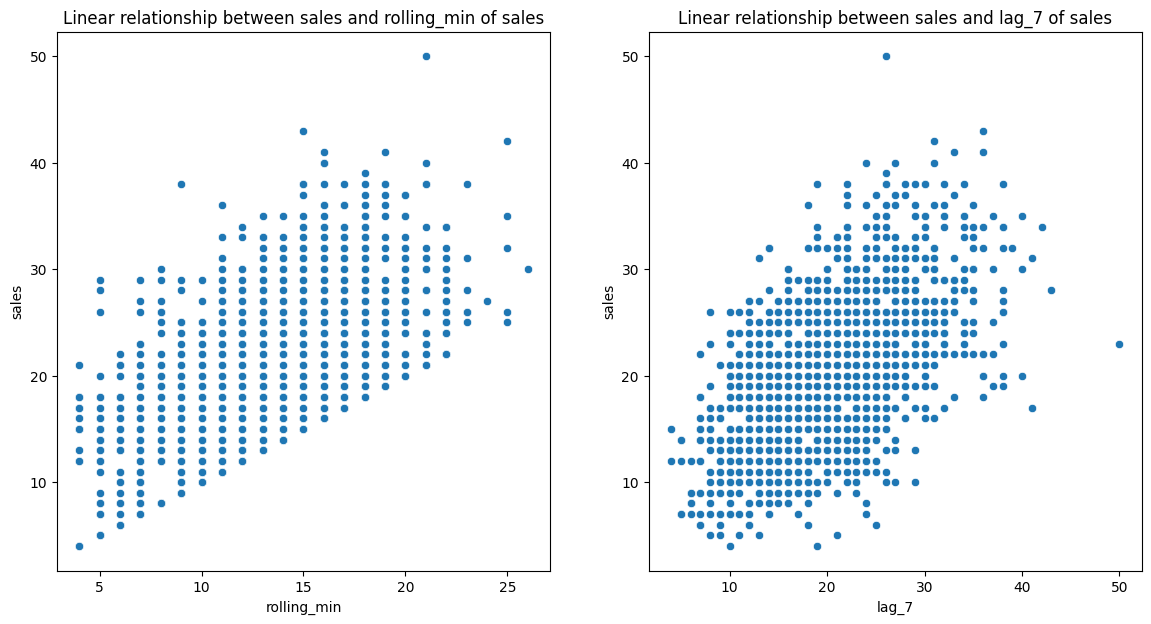

In [45]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(x='rolling_mean', y='sales', data=reg_train_df, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(x='rolling_max', y='sales', data=reg_train_df, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(x='rolling_min', y='sales', data=reg_train_df, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(x='lag_7', y='sales', data=reg_train_df, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [46]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

Model Evaluation and Predictions

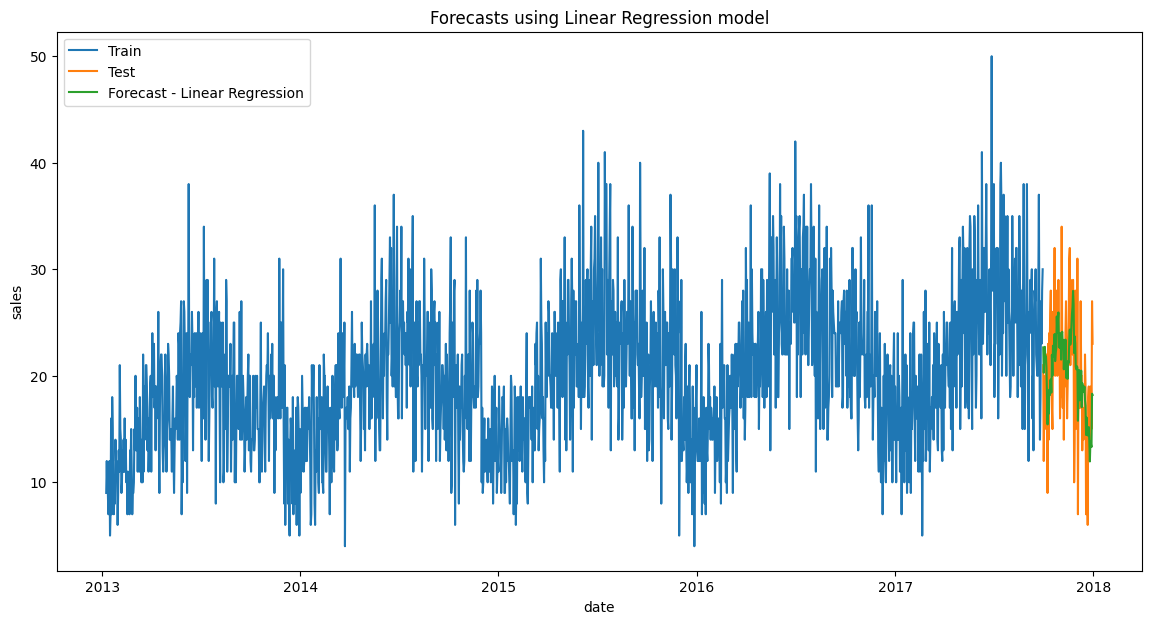

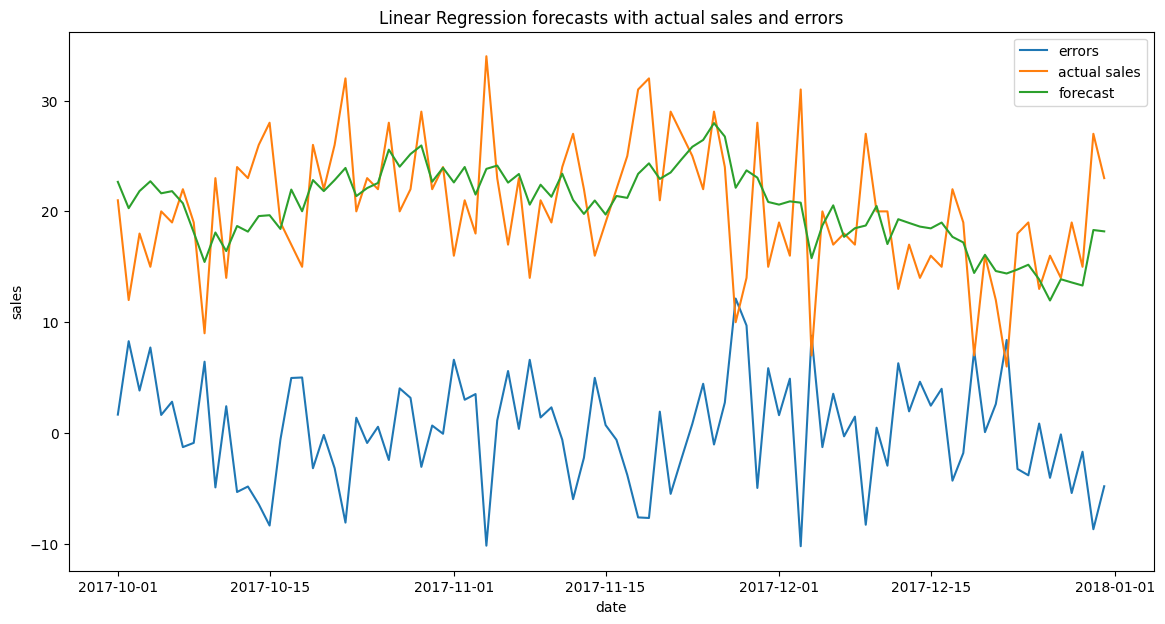

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1861,1882.074831,21.074831,3.858646,4.786183,19.075519


In [47]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_lr

Inference: The Linear regression model captures the upwards as well as the downwards movement in the sales data. Its performance, MAPE 19.07% , is better than the Holt-Winters model which was the best performing model so far.